# Understanding the ReAct pattern

Langgraph's ReAct pattern based React agents are a nice patter which we can use to quickly start building our AI agent.

It's simple API allows us to create AI agents with tools and have supervisors.

In [ ]:
! pip install langgraph-supervisor langchain-openai python-dotenv

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
from dotenv import load_dotenv
import random
import os

load_dotenv()

OPENAI_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_MODEL = os.getenv("OPENAI_MODEL")

## Getting an instance of our Model

In [58]:
model = ChatOpenAI(
    model=OPENAI_MODEL,
    api_key=OPENAI_KEY,
)

## Defining our tools

Defining our tools here for the food recommendation agent.

Right now, we have kept things simple and just sending a random name 
from a list.

### Food recommendation tools

In [99]:
def get_random_fruit() -> str:
    """Return a random fruit name."""
    words = ["Apple", "Banana", "Cherry", "Date", "Mango", "Grapes", "Orange"]
    recommend = random.choice(words)
    return recommend


def get_random_vegetable() -> str:
    """Return a random vegetable name."""
    words = ["Carrot", "Broccoli", "Spinach", "Potato", "Tomato", "Cucumber"]
    recommend = random.choice(words)
    return recommend

In [100]:
food_expert = create_react_agent(
    model=model,
    tools=[get_random_fruit, get_random_vegetable],
    name="food_expert",
    prompt="You are a food expert. Recommend a fruit and a vegetable for a healthy snack. Use one tool at a time.",
)

In [101]:
workflow = create_supervisor(
    [food_expert],
    model=model,
    prompt="You are a team supervisor managing a food recommendation expert. Use food_expert to get a fruit and a vegetable recommendation. After you have called both tools and presented your recommendation, STOP and do not call any more tools.",
    output_mode="full_history",
)

In [102]:
app = workflow.compile()

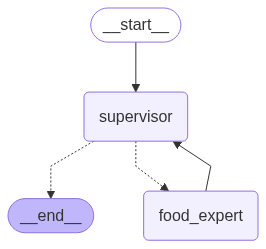

In [103]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [106]:
result = app.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "I want a healthy snack recommendation. Can you suggest something that is sweet?",
            }
        ]
    },
    config={"recursion_limit": 5},
)

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


## Showing the result

Now that we have got the results, we will loop through the entire message history

and print each event to show how the entire graph was executed.

In [105]:
for msg in result["messages"]:
    name = getattr(msg, "name", None) or (
        msg.get("name") if isinstance(msg, dict) else None
    )
    content = getattr(msg, "content", None) or (
        msg.get("content") if isinstance(msg, dict) else None
    )
    print(f"Event {name} -> {content} \n")

Event None -> I want a healthy snack recommendation. Can you suggest something? 

Event supervisor -> None 

Event transfer_to_food_expert -> Successfully transferred to food_expert 

Event food_expert -> None 

Event get_random_fruit -> Banana 

Event get_random_vegetable -> Spinach 

Event food_expert -> A healthy snack idea would be a banana and spinach. You can enjoy a banana on its own or add some spinach to a smoothie for an extra boost of nutrients. 

Event food_expert -> Transferring back to supervisor 

Event transfer_back_to_supervisor -> Successfully transferred back to supervisor 

Event supervisor -> A healthy snack recommendation would be to enjoy a banana, which is rich in vitamins and natural sugars, or incorporate spinach into a smoothie for extra nutrients and fiber. 

